In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras.utils.np_utils import to_categorical
from tqdm.keras import TqdmCallback

from src.data.traceloader import AscadRandomKey

sns.set_style('whitegrid')

In [17]:
# 9 classes for a HW of [0..8]
NUM_CLASSES = 9

In [18]:
ascad = AscadRandomKey()
profile = ascad.default.profile.traces, ascad.default.profile.hw_labels()
attack = ascad.default.attack.traces, ascad.default.attack.hw_labels()

In [19]:
sum(profile[1][:100])

394

### Normalize traces

In [20]:
prof_mean, prof_std = profile[0].mean(axis=0), profile[0].std(axis=0)
x_prof = (profile[0] - prof_mean) / prof_std
x_att = (attack[0] - prof_mean) / prof_std

### Encode labels

One-hot encode the hamming weight labels.

In [21]:
y_prof = to_categorical(profile[1], num_classes=NUM_CLASSES)
y_att = to_categorical(attack[1], num_classes=NUM_CLASSES)

### Model creation

With model hyperparameters to be optimized.

In [22]:
model_parameters = {
    'activation': ['relu'],
    'optimizer': [Adam(lr=0.001)],
    'losses': ['categorical_crossentropy'],
    'batch_size': list(np.linspace(100, 300, 5).astype(int)),
    'epochs': list(np.linspace(5, 20, 4).astype(int))
}

def make_mlp(x, y, x_attack, y_attack, params, verbose=False):
    mdl = Sequential()
    mdl.add(Dense(100, activation=params['activation'], input_shape=(1400,)))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(NUM_CLASSES, activation='softmax'))

    mdl.compile(optimizer=params['optimizer'], loss=params['losses'], metrics=['accuracy'])

    out = mdl.fit(x, y, shuffle=True, validation_data=(x_attack, y_attack), batch_size=params['batch_size'],
                  epochs=params['epochs'], verbose=False, callbacks=[TqdmCallback(verbose=0)])

    return out, mdl

### Brute-force Hyper parameter optimization

Talos brute-force scan for optimal hyperparameters

In [23]:
# import talos
#
# scan_obj = talos.Scan(x=x_prof,    y=y_prof,    x_val=x_att,    y_val=y_att,    model=make_mlp,    params=model_parameters,    experiment_name="talos", print_params=True)

### Fit model based on the optimal model found by Talos.

In [24]:
best_model = make_mlp(x_prof, y_prof, x_att, y_att, {
    'activation':'relu',
    'optimizer': Adam(lr=0.001),
    'losses': 'categorical_crossentropy',
    'batch_size': 150,
    'epochs': 5
}, True)[1]

### HW Prediction

Predict the hamming weight by taking the weighted mean for the predicted probabilities for each class.

#### Example: Some prediction

Probabilities for each class:

In [25]:
best_model.predict(x_att[:1])[0]

array([0.00251021, 0.0325679 , 0.11213744, 0.22989422, 0.28685433,
       0.22081874, 0.0974118 , 0.01660134, 0.00120405], dtype=float32)

**Predicted hamming weight label**, calculated by taking the weighted mean using the predicted probabilities.

In [26]:
np.sum(best_model.predict(x_att[:1])[0] * range(8 + 1))

3.908349107950926

In [27]:
def hamming_weight_prediction(mdl: Model, x, num_rows=None):
    pred = mdl.predict(x)[:num_rows]
    return np.sum(pred * range(9), axis=1)

In [28]:
def split_by_hw(x_attack, y_attack):
    """
    Split traces in two classes.
    Class A: the hamming weight label is below 4, and class B: above 4.

    Returns traces for classes A and B
    """
    hws = np.argmax(y_attack, axis=1)

    l4 = x_attack[np.where(hws < 4)]
    g4 = x_attack[np.where(hws > 4)]

    return l4, g4

### Plot prediction distribution for all traces.

[Text(0.5, 0, 'Predicted hamming weight, bin size = 0.1'),
 Text(0.5, 1.0, 'Attack trace predictions for 72727 sample traces.')]

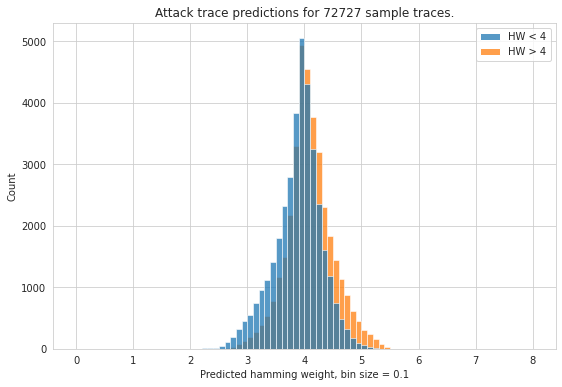

In [29]:
less_4, greater_4 = split_by_hw(x_att, y_att)

num_all = len(less_4) + len(greater_4)

plt.figure(figsize=(9, 6))

graph1 = sns.histplot(data={
    "HW < 4": hamming_weight_prediction(best_model, less_4),
    "HW > 4": hamming_weight_prediction(best_model, greater_4)
}, bins=80, binrange=(0,8))
graph1.set(xlabel="Predicted hamming weight, bin size = 0.1",
           title=f"Attack trace predictions for {num_all} sample traces.")

In [30]:
def p_gradient_dl_la(mdl: Model, x_attack, y_attack, max_traces):
    """
    Creates a gradient of the p-value that predictions for A and B follow the same distribution.
    Class A consists of traces which are labelled with a hamming weight below 4 and class B above 4.

    Calculates 100 steps between 2 traces and a provided maximum number of traces.
    """
    l4, g4 = split_by_hw(x_attack, y_attack)
    nr = min(len(l4), len(g4), max_traces)

    pred_l4 = hamming_weight_prediction(mdl, l4, nr)
    pred_g4 = hamming_weight_prediction(mdl, g4, nr)
    pred_l4_inner = pred_l4.copy()

    np.random.shuffle(pred_l4)
    np.random.shuffle(pred_g4)

    ixs = np.linspace(2, nr, 100).astype(int)
    gradient, inner_gradient = [], []
    for i in ixs:
        p_val = stats.ttest_ind(pred_l4[:i], pred_g4[:i], equal_var=False)[1]
        p_val_inner = stats.ttest_ind(pred_l4[:i], pred_l4_inner[:i], equal_var=False)[1]

        gradient.append(p_val)
        inner_gradient.append(p_val_inner)

    df = pd.DataFrame({"A vs. B": gradient, "A vs. A": inner_gradient})
    df = df.set_index(ixs, drop=True)

    return df

### Plot p-gradient.

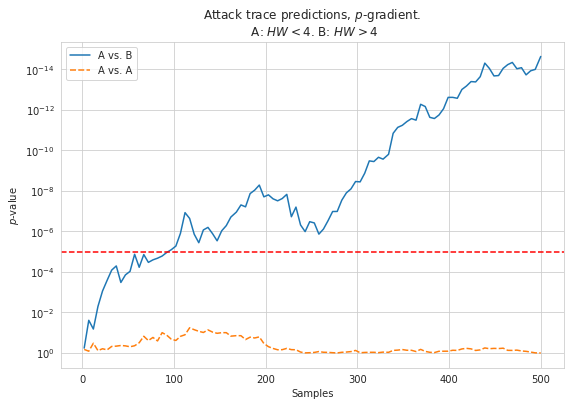

In [31]:
plt.figure(figsize=(9, 6))

graph2 = sns.lineplot(data=p_gradient_dl_la(best_model, x_att, y_att, 500))
graph2.set(yscale="log", xlabel="Samples", ylabel="$p$-value",
           title="Attack trace predictions, $p$-gradient.\n A: $HW < 4$. B: $HW > 4$")
graph2.invert_yaxis()
graph2.axhline(10 ** -5, ls='--', color="red")
